---
title: "Poster for ASHG 2024, Denver CO"
author: "Saikat Banerjee"
format:
  html: default
date: "2024-10-31"
file-modified: "2024-11-01"
abstract: "High quality plots used in the poster for ASHG 2024, using NYGC color palette."

---

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import re

import matplotlib
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

import scipy.stats as sc_stats
import collections
import textalloc

# For OpenTargets API
import requests
import json

# Setup

In [2]:
import matplotlib.font_manager as mpl_fm
font_path = '/gpfs/commons/home/sbanerjee/nygc/Futura'
mpl_fm.fontManager.addfont(font_path + '/FuturaStd-Book.otf') # Loads "Futura Std"

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)
# futura_book = FontProperties(fname='/gpfs/commons/home/sbanerjee/nygc/Futura/FuturaStd-Book.otf')

# NYGC Color Palette
nygc_colors = {
    'brown': '#7F0814',
    'darkred': '#d42e12',
    'orange': '#F37239',
    'darkyellow': '#F79320',
    'yellow': '#FFE438',
    'darkblue': '#003059',
    'blue': '#266DB6',
    'lightblue': '#A3D5ED',
    'darkgreen': '#006838',
    'green': '#0A8A42',
    'lightgreen': '#74B74A',
    'yellowgreen': '#BAD75F',
    'darkgray': '#1A1A1A',
    'gray': '#666666',
    'lightgray': '#CCCCCC',
    'khaki': '#ADA194',
    'darkkhaki': '#5E514D',
}

# Style sheet for NYGC poster
mpl_stylesheet.banskt_presentation(dpi = 300, fontsize = 28, 
    splinecolor = nygc_colors['darkgray'], black = nygc_colors['darkgray'])
plt.rcParams['font.family'] = 'Futura Std'

In [3]:
def iqr_outlier(x, axis = None, bar = 1.5, side = 'both'):
    assert side in ['gt', 'lt', 'both'], 'Side should be `gt`, `lt` or `both`.'
    
    def q1(x, axis = None):
        return np.percentile(x, 25, axis = axis)

    def q3(x, axis = None):
        return np.percentile(x, 75, axis = axis)

    d_iqr = sc_stats.iqr(x, axis = axis)
    d_q1 = q1(x, axis = axis)
    d_q3 = q3(x, axis = axis)
    iqr_distance = np.multiply(d_iqr, bar)

    stat_shape = list(x.shape)

    if isinstance(axis, collections.abc.Iterable):
        for single_axis in axis:
            stat_shape[single_axis] = 1
    else:
        stat_shape[axis] = 1

    if side in ['gt', 'both']:
        upper_range = d_q3 + iqr_distance
        upper_outlier = np.greater(x - upper_range.reshape(stat_shape), 0)
    if side in ['lt', 'both']:
        lower_range = d_q1 - iqr_distance
        lower_outlier = np.less(x - lower_range.reshape(stat_shape), 0)

    if side == 'gt':
        return upper_outlier
    if side == 'lt':
        return lower_outlier
    if side == 'both':
        return np.logical_or(upper_outlier, lower_outlier)

In [4]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/npddata/panukb/results/colormann-svd"

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_noRx.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_all_with_desc.pkl"))

variant_filename = f"{data_dir}/allvar.pruned.closesttss.hugo"
variant_df = pd.read_csv(variant_filename, sep = '\t')

nsample_filename = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data/phe2483.SampleN.tsv"
nsample_df = pd.read_csv(nsample_filename, sep = '\t')

In [5]:
methods = ["nnm", "nnm-sparse", "rpca"]
method_names = {
    "nnm" : "NNM",
    "nnm-sparse" : "NNM-Sparse",
    "rpca" : "Robust PCA"
}

res_pklfile = {
    "nnm": "nnm_model_r155872_iter1000.pkl",
    "nnm-sparse": "nnm_sparse_model_r155872_iter1000.pkl",
    "rpca": "rpca_model.pkl"
}

pca_comps = dict()
mf_comps = dict()
k = 200

for method in methods:
    comps_filename = os.path.join(result_dir, method, "noRx", "pca_comps.pkl")
    with open(comps_filename, "rb") as mfile:
        pca_comps[method] = pickle.load(mfile)
    mf_comps_filename = os.path.join(result_dir, method, "noRx", f"mf_comps_k{k}.pkl")
    with open(mf_comps_filename, "rb") as mfile:
        mf_comps[method] = pickle.load(mfile)
        
X = np.array(zscore_df.values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)

In [6]:
pheno_zindex = [int(x[1:]) for x in zscore_df.columns]
trait_df_noRx = trait_df.loc[trait_df['zindex'].isin(pheno_zindex)]
nsample_df_noRx = nsample_df.loc[trait_df_noRx.index]
trait_df_noRx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2110 entries, 0 to 2482
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zindex                       2110 non-null   int64  
 1   trait_type                   2110 non-null   object 
 2   phenocode                    2110 non-null   object 
 3   pheno_sex                    2110 non-null   object 
 4   coding                       267 non-null    object 
 5   modifier                     394 non-null    object 
 6   description                  2110 non-null   object 
 7   description_more             1408 non-null   object 
 8   coding_description           261 non-null    object 
 9   category                     2072 non-null   object 
 10  BIN_QT                       2110 non-null   object 
 11  n_cases_EUR                  2110 non-null   int64  
 12  n_controls_EUR               1304 non-null   float64
 13  N                      

In [7]:
focal_disease = {
    "opentarget_name" : "type 1 diabetes mellitus",
    "opentarget_id": "MONDO_0005147",
    "df_query_string": "Type 1 diabetes",
}

trait_df_noRx.query(f"description == '{focal_disease['df_query_string']}'")

,zindex,trait_type,phenocode,pheno_sex,coding,modifier,description,description_more,coding_description,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,filename,aws_link,estimates.final.h2_observed,long_description,short_description
458,459,phecode,250.1,both_sexes,NaN,NaN,Type 1 diabetes,NaN,NaN,endocrine/metabolic,BIN,3250,396181.0,399431,6447.112267,phecode-250.1-both_sexes.tsv.bgz,https://pan-ukb-us-east-1.s3.amazonaws.com/sum...,0.0088,Type 1 diabetes,Type 1 diabetes


In [14]:
zindex = trait_df_noRx.query(f"description == '{focal_disease['df_query_string']}'")["zindex"].values[0]
method = "nnm-sparse"

trait_indices = np.array(trait_df_noRx.index)
tidx = np.searchsorted(trait_indices, zindex - 1)

loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps[method]
top_factor1 = np.argsort(cos2_pheno[tidx,:])[::-1][0]
top_factor2 = np.argsort(cos2_pheno[tidx,:])[::-1][1]

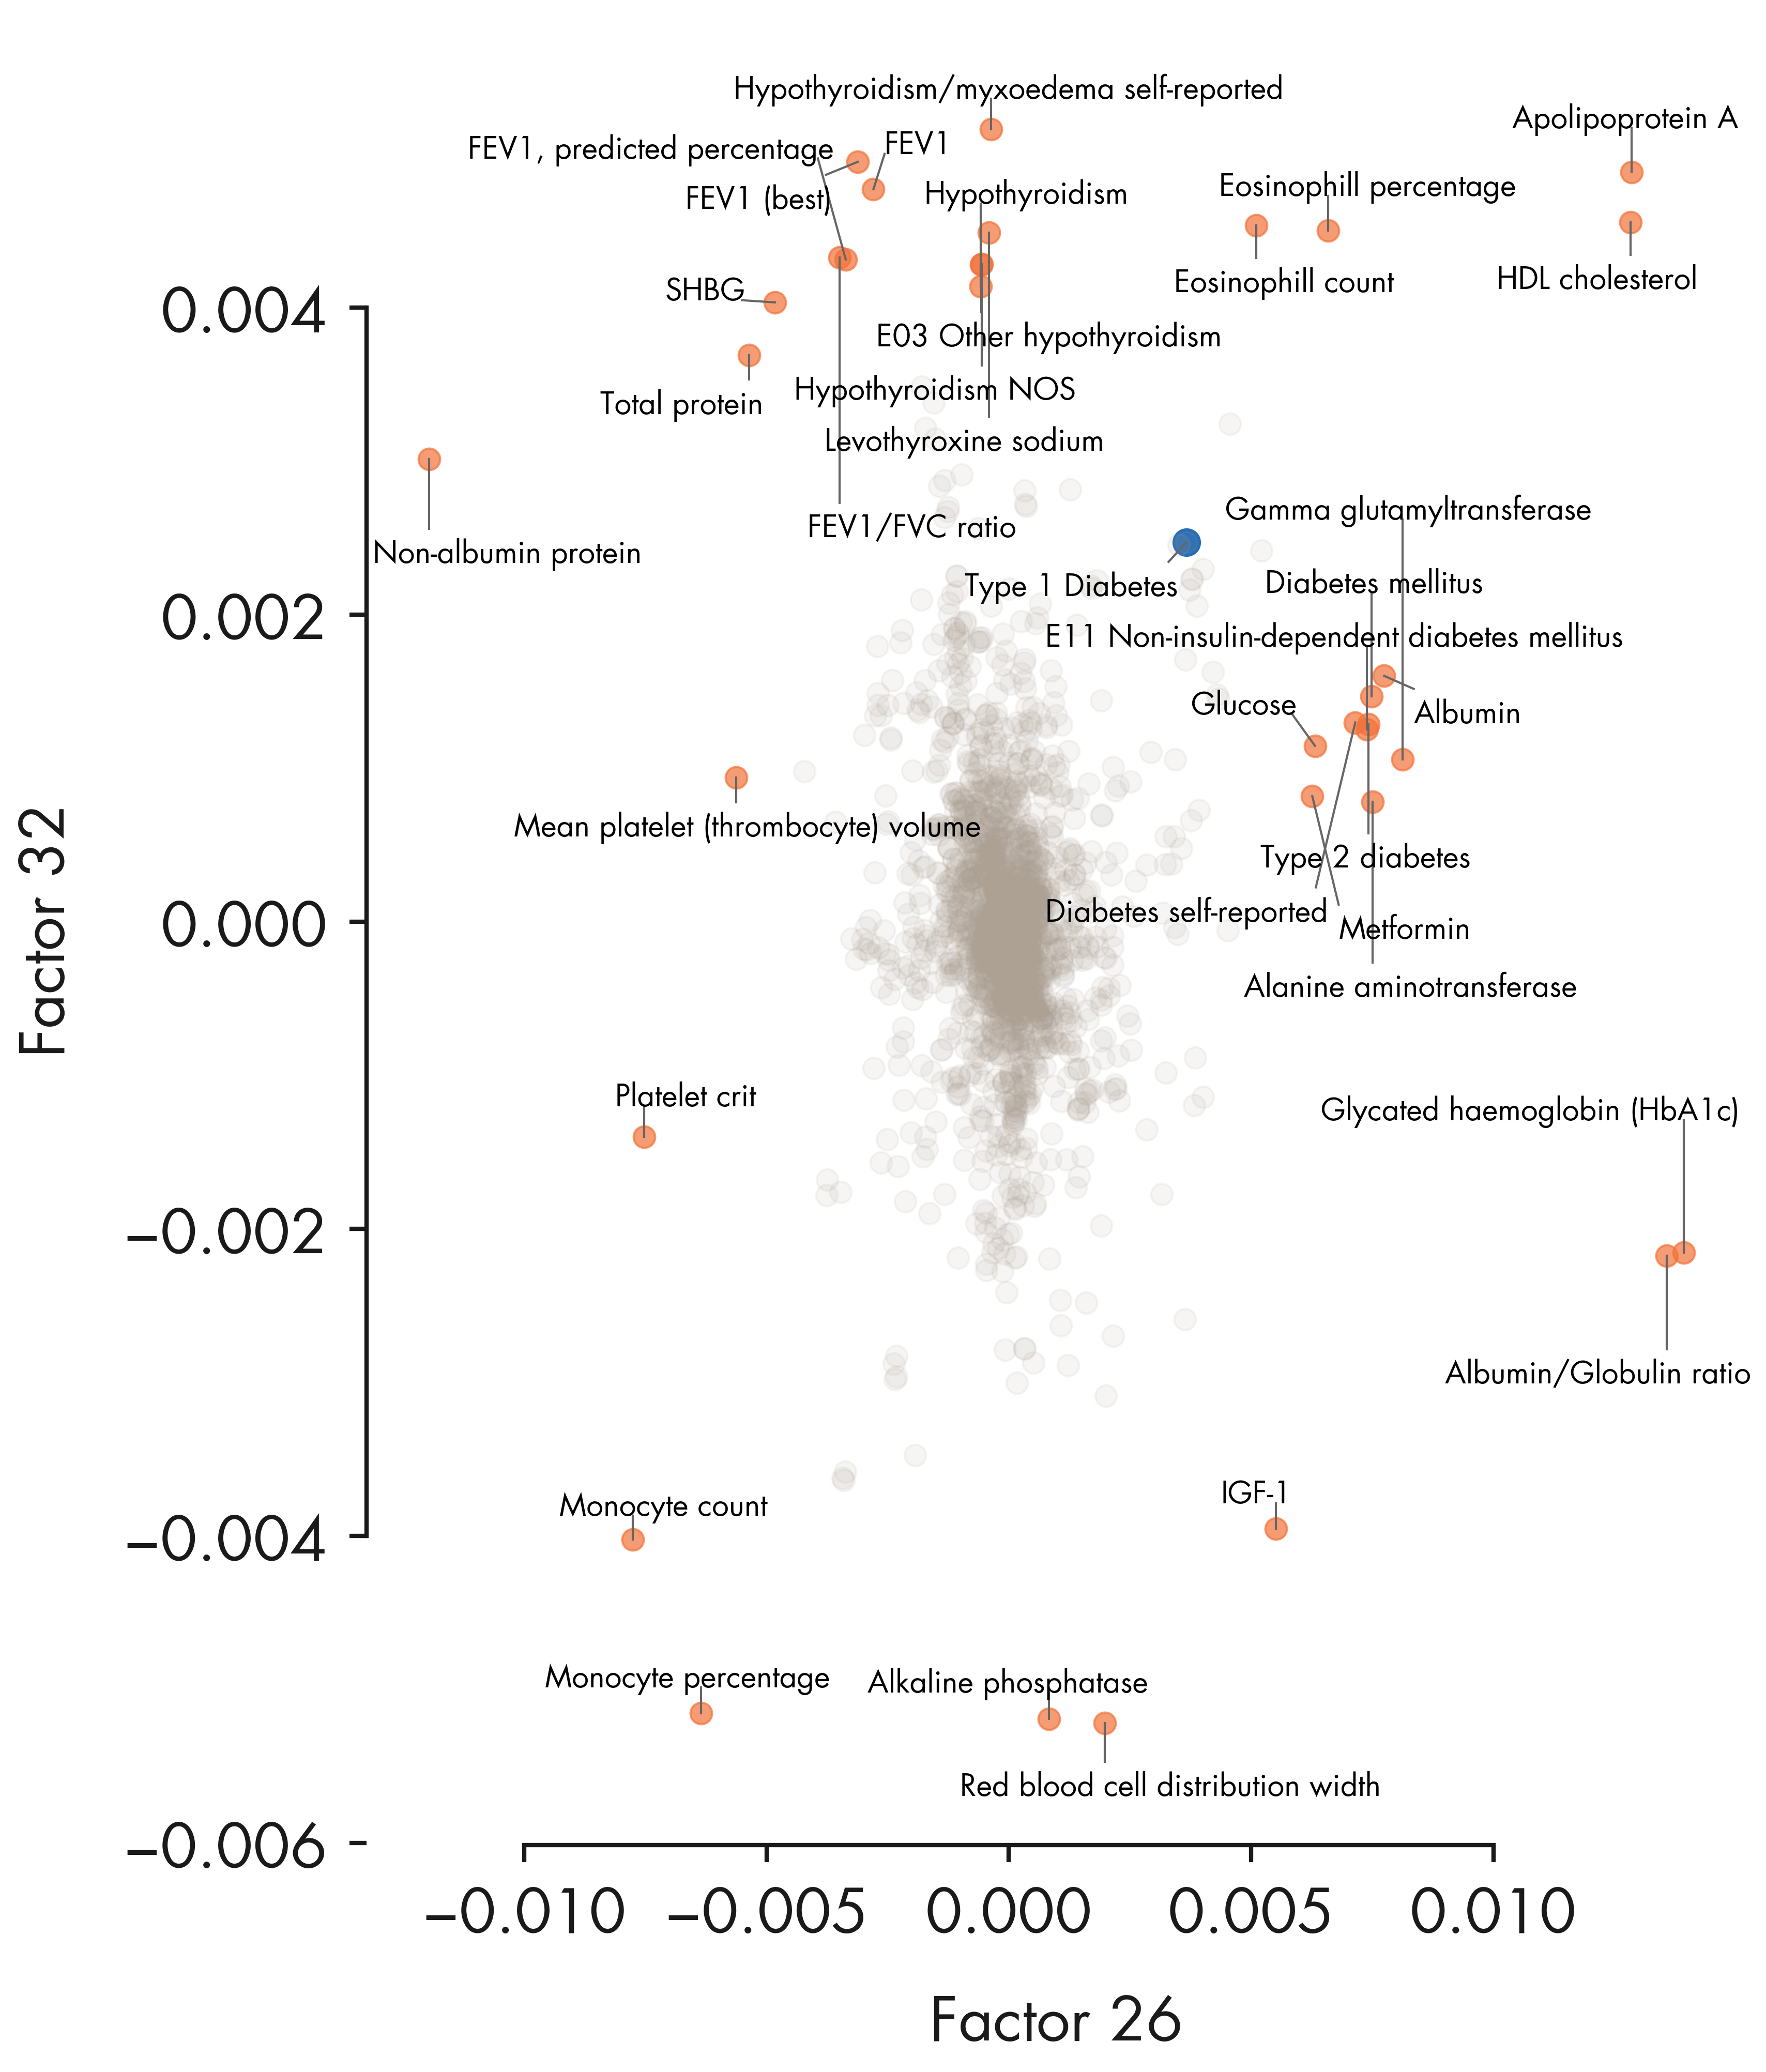

In [15]:
fig = plt.figure(figsize = (12, 14))
ax1 = fig.add_subplot(111)
# ax1.set_aspect('equal')

xvals = loadings[:, top_factor1]
yvals = - loadings[:, top_factor2]
    

# Combine outliers in x-axis and y-axis
# outlier_idx_x = np.where(iqr_outlier(xvals, axis = 0, bar = 5.0))[0]
# outlier_idx_y = np.where(iqr_outlier(yvals, axis = 0, bar = 5.0))[0]
outlier_idx_x = np.argsort(contribution_pheno[:, top_factor1])[::-1][:20]
outlier_idx_y = np.argsort(contribution_pheno[:, top_factor2])[::-1][:20]
outlier_idx = np.union1d(outlier_idx_x, outlier_idx_y)
x_center = np.mean(ax1.get_xlim())
common_idx = np.setdiff1d(np.arange(xvals.shape[0]), outlier_idx)

scatter_plot = ax1.scatter(xvals[outlier_idx], yvals[outlier_idx], alpha = 0.7, s = 100, color = nygc_colors['orange'])
ax1.scatter(xvals[tidx], yvals[tidx], s = 150, color = nygc_colors['blue'])
ax1.scatter(xvals[common_idx], yvals[common_idx], alpha = 0.1, s = 100, color = nygc_colors['khaki'])

# # Mark using adjustText package
# # https://github.com/Phlya/adjustText
# annots = []
# for i in outlier_idx:
#     txt = trait_df.loc[trait_indices[i]]['description'].strip()
#     if 'intima-medial thickness' in txt:
#         continue
#     if xvals[i] > x_center:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 6, ha = 'right')]
#     else:
#         annots += [ax1.annotate(txt, (xvals[i], yvals[i]), fontsize = 6)]
# # Adjust the annotations iteratively
# adjust_text(annots, arrowprops=dict(arrowstyle='-', color = 'grey'))

# Mark using textalloc package
txt_list = []
text_idx_list = []
for i in outlier_idx:
    txt = trait_df_noRx.loc[trait_indices[i]]['short_description'].strip()
    txt_list.append(txt)
    text_idx_list.append(i)
    
# Mark Type 1 diabetes
txt_list.append("Type 1 Diabetes")
text_idx_list.append(tidx)
if len(text_idx_list) > 0:
    txt_idx = np.array(text_idx_list)
    textalloc.allocate_text(fig, ax1, xvals[txt_idx], yvals[txt_idx], txt_list,
                            # x_scatter = xvals, y_scatter = yvals,
                            scatter_plot = scatter_plot,
                            textsize = 14, textcolor = 'black', linecolor = nygc_colors['gray'])


ax1.set_xticks([-0.010, -0.005, 0.0, 0.005, 0.010])
for side, border in ax1.spines.items():
    if side == 'left':
        border.set_bounds(-0.004, 0.004)
    elif side == 'bottom':
        border.set_bounds(-0.01, 0.01)
    else:
        border.set_visible(False)
ax1.set_xlabel(f"Factor {top_factor1 + 1}")
ax1.set_ylabel(f"Factor {top_factor2 + 1}")
    
plt.tight_layout()
plt.savefig('../plots/ashg24/phenotype_contributions_top2factors_t1d.png', bbox_inches='tight')
plt.show()

In [16]:
def get_opentarget_score(gene_id):

    # Build query string to get association information
    query_string = """
        query TargetAssociationsQuery(
          $ensemblId: String!
          $filter: String
          $sortBy: String!
          $enableIndirect: Boolean!
        ) {
          target(ensemblId: $ensemblId) {
            id
            approvedSymbol
            associatedDiseases(
              orderByScore: $sortBy
              BFilter: $filter
              enableIndirect: $enableIndirect
            ) {
              count
              rows {
                disease {
                  id
                  name
                }
                score
              }
            }
          }
        }

    """

    # Set variables object of arguments to be passed to endpoint
    variables = {
        "ensemblId": gene_id, 
        "filter": focal_disease["opentarget_name"],
        "sortBy": "score",
        "enableIndirect": False
    }

    # Set base URL of GraphQL API endpoint
    base_url = "https://api.platform.opentargets.org/api/v4/graphql"
    # print (gene_id)

    # Perform POST request and check status code of response
    r = requests.post(base_url, json={"query": query_string, "variables": variables})
    # print(r.status_code)

    # Transform API response from JSON into Python dictionary and print in console
    api_response = json.loads(r.text)
    # print(api_response)

    score = 0.0
    if api_response['data']['target'] is not None:
        associated_diseases = api_response['data']['target']['associatedDiseases']['rows']
        for d in associated_diseases:
            if d['disease']['id'] == focal_disease["opentarget_id"]:
                score = d['score']
    # print(score)
    return score

def get_variant_names(df):
    vstr_list = list()
    for i in range(df.shape[0]):
        vstr = 'chr' + df.iloc[i][['chr', 'rsid', 'Gene_name']].astype('str').str.cat(sep=' | ')
        gene_id = df.iloc[i]['ensembl_gene_id']
        if not pd.isna(gene_id):
            assoc_score = get_opentarget_score(gene_id)
            vstr += f" | {assoc_score:.3f}"
        else:
            vstr += f" | NaN"
        vstr_list.append(vstr)
    return vstr_list

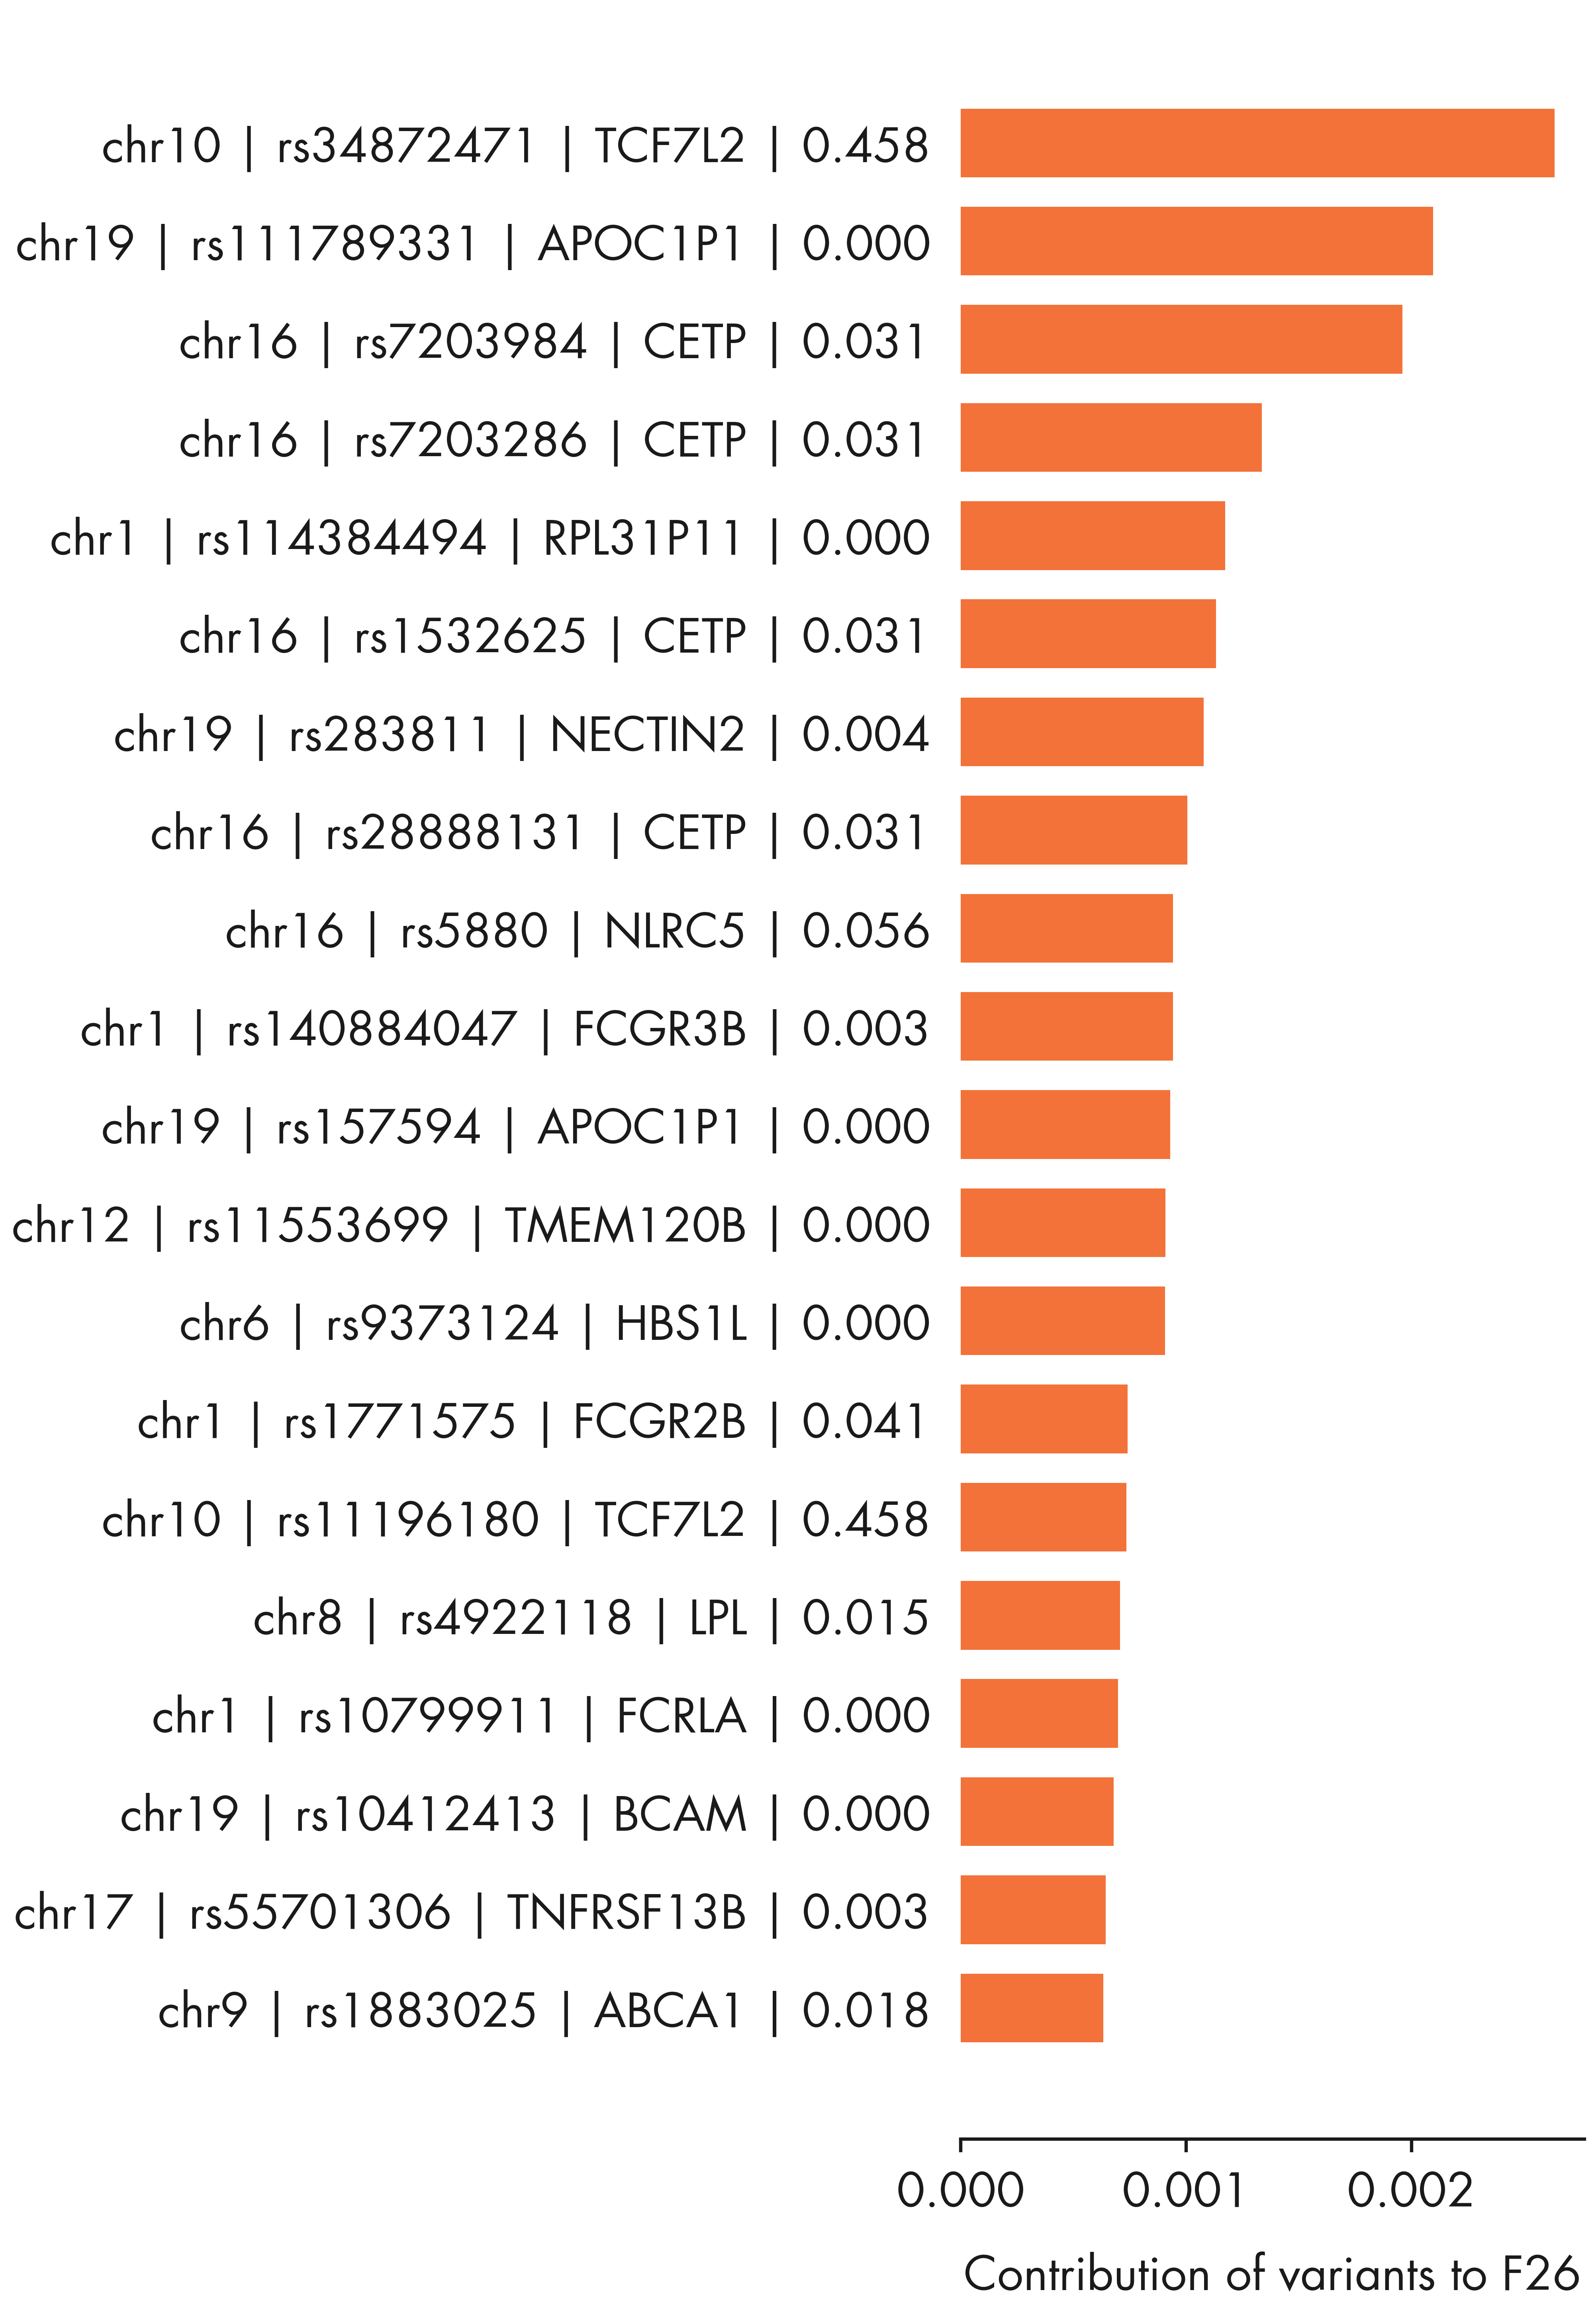

In [37]:
fig = plt.figure(figsize = (14, 20))
ax1 = fig.add_subplot(111)

n_plot_variants = 20


top_variant_idx = np.argsort(contribution_variant[:, top_factor1])[::-1][:n_plot_variants]
top_variant_df = variant_df.loc[zscore_df.index.to_numpy()[top_variant_idx]]
top_variant_score = contribution_variant[top_variant_idx, top_factor1]
    
top_variant_names = get_variant_names(top_variant_df)
    
xvals = top_variant_score
yvals = np.arange(n_plot_variants)[::-1]

ax1.barh(yvals, xvals, align = 'center', height = 0.7, color = nygc_colors['orange'], edgecolor = 'None')
ax1.set_yticks(yvals)
ax1.set_yticklabels(top_variant_names)

for side in ['top', 'right', 'left']:
    ax1.spines[side].set_visible(False)

ax1.tick_params(left=False)
ax1.set_xlabel(f"Contribution of variants to F{top_factor1 + 1}")
# ax1.set_title(method_names[method])

plt.tight_layout()
plt.savefig('../plots/ashg24/variant_contributions_topfactor_t1d.png', bbox_inches='tight')
plt.show()

In [31]:
cts_resdir = "/gpfs/commons/home/sbanerjee/npddata/panukb/results/ldsc"
cts_resfile = os.path.join(cts_resdir, method, "enrich", f"factor_{top_factor1}_sumstat.Multi_tissue_gene_expr.cell_type_results.txt")
n_plot_tissues = 10

cts_df = pd.read_csv(cts_resfile, sep="\t").sort_values(by=["Coefficient_P_value"]).head(n_plot_tissues)
cts_df

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value
26,Pancreas,1.001480e-07,3.094918e-08,0.000606
104,A03.620.Liver,8.893163e-08,3.108535e-08,0.002112
78,A03.556.249.124.Ileum,1.182039e-07,4.152288e-08,0.002209
0,Breast_Mammary_Tissue,7.025016e-08,2.680537e-08,0.004387
105,A03.556.124.369.Intestinal.Mucosa,1.062804e-07,4.059941e-08,0.004425
106,A05.810.453.Kidney,7.182063e-08,2.803494e-08,0.005206
182,A10.165.114.830.750.Subcutaneous.Fat,7.103804e-08,2.815409e-08,0.005815
183,A11.872.190.Embryonic.Stem.Cells,8.099203e-08,3.233840e-08,0.006131
27,Small_Intestine_Terminal_Ileum,8.611025e-08,3.465571e-08,0.006482
28,Kidney_Cortex,7.244011e-08,2.935974e-08,0.006806


In [33]:
cts_df["Name"] = ["Pancreas", "Liver", "Ileum", "Breast Mammary Tissue", "Intestinal Mucosa",
                        "Kidney", "Subcutaneous Fat", "Embryonic Stem Cells", 
                        "Small Intestine Terminal Ileum", "Kidney Cortex"]
cts_df

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value
26,Pancreas,1.001480e-07,3.094918e-08,0.000606
104,Liver,8.893163e-08,3.108535e-08,0.002112
78,Ileum,1.182039e-07,4.152288e-08,0.002209
0,Breast Mammary Tissue,7.025016e-08,2.680537e-08,0.004387
105,Intestinal Mucosa,1.062804e-07,4.059941e-08,0.004425
106,Kidney,7.182063e-08,2.803494e-08,0.005206
182,Subcutaneous Fat,7.103804e-08,2.815409e-08,0.005815
183,Embryonic Stem Cells,8.099203e-08,3.233840e-08,0.006131
27,Small Intestine Terminal Ileum,8.611025e-08,3.465571e-08,0.006482
28,Kidney Cortex,7.244011e-08,2.935974e-08,0.006806


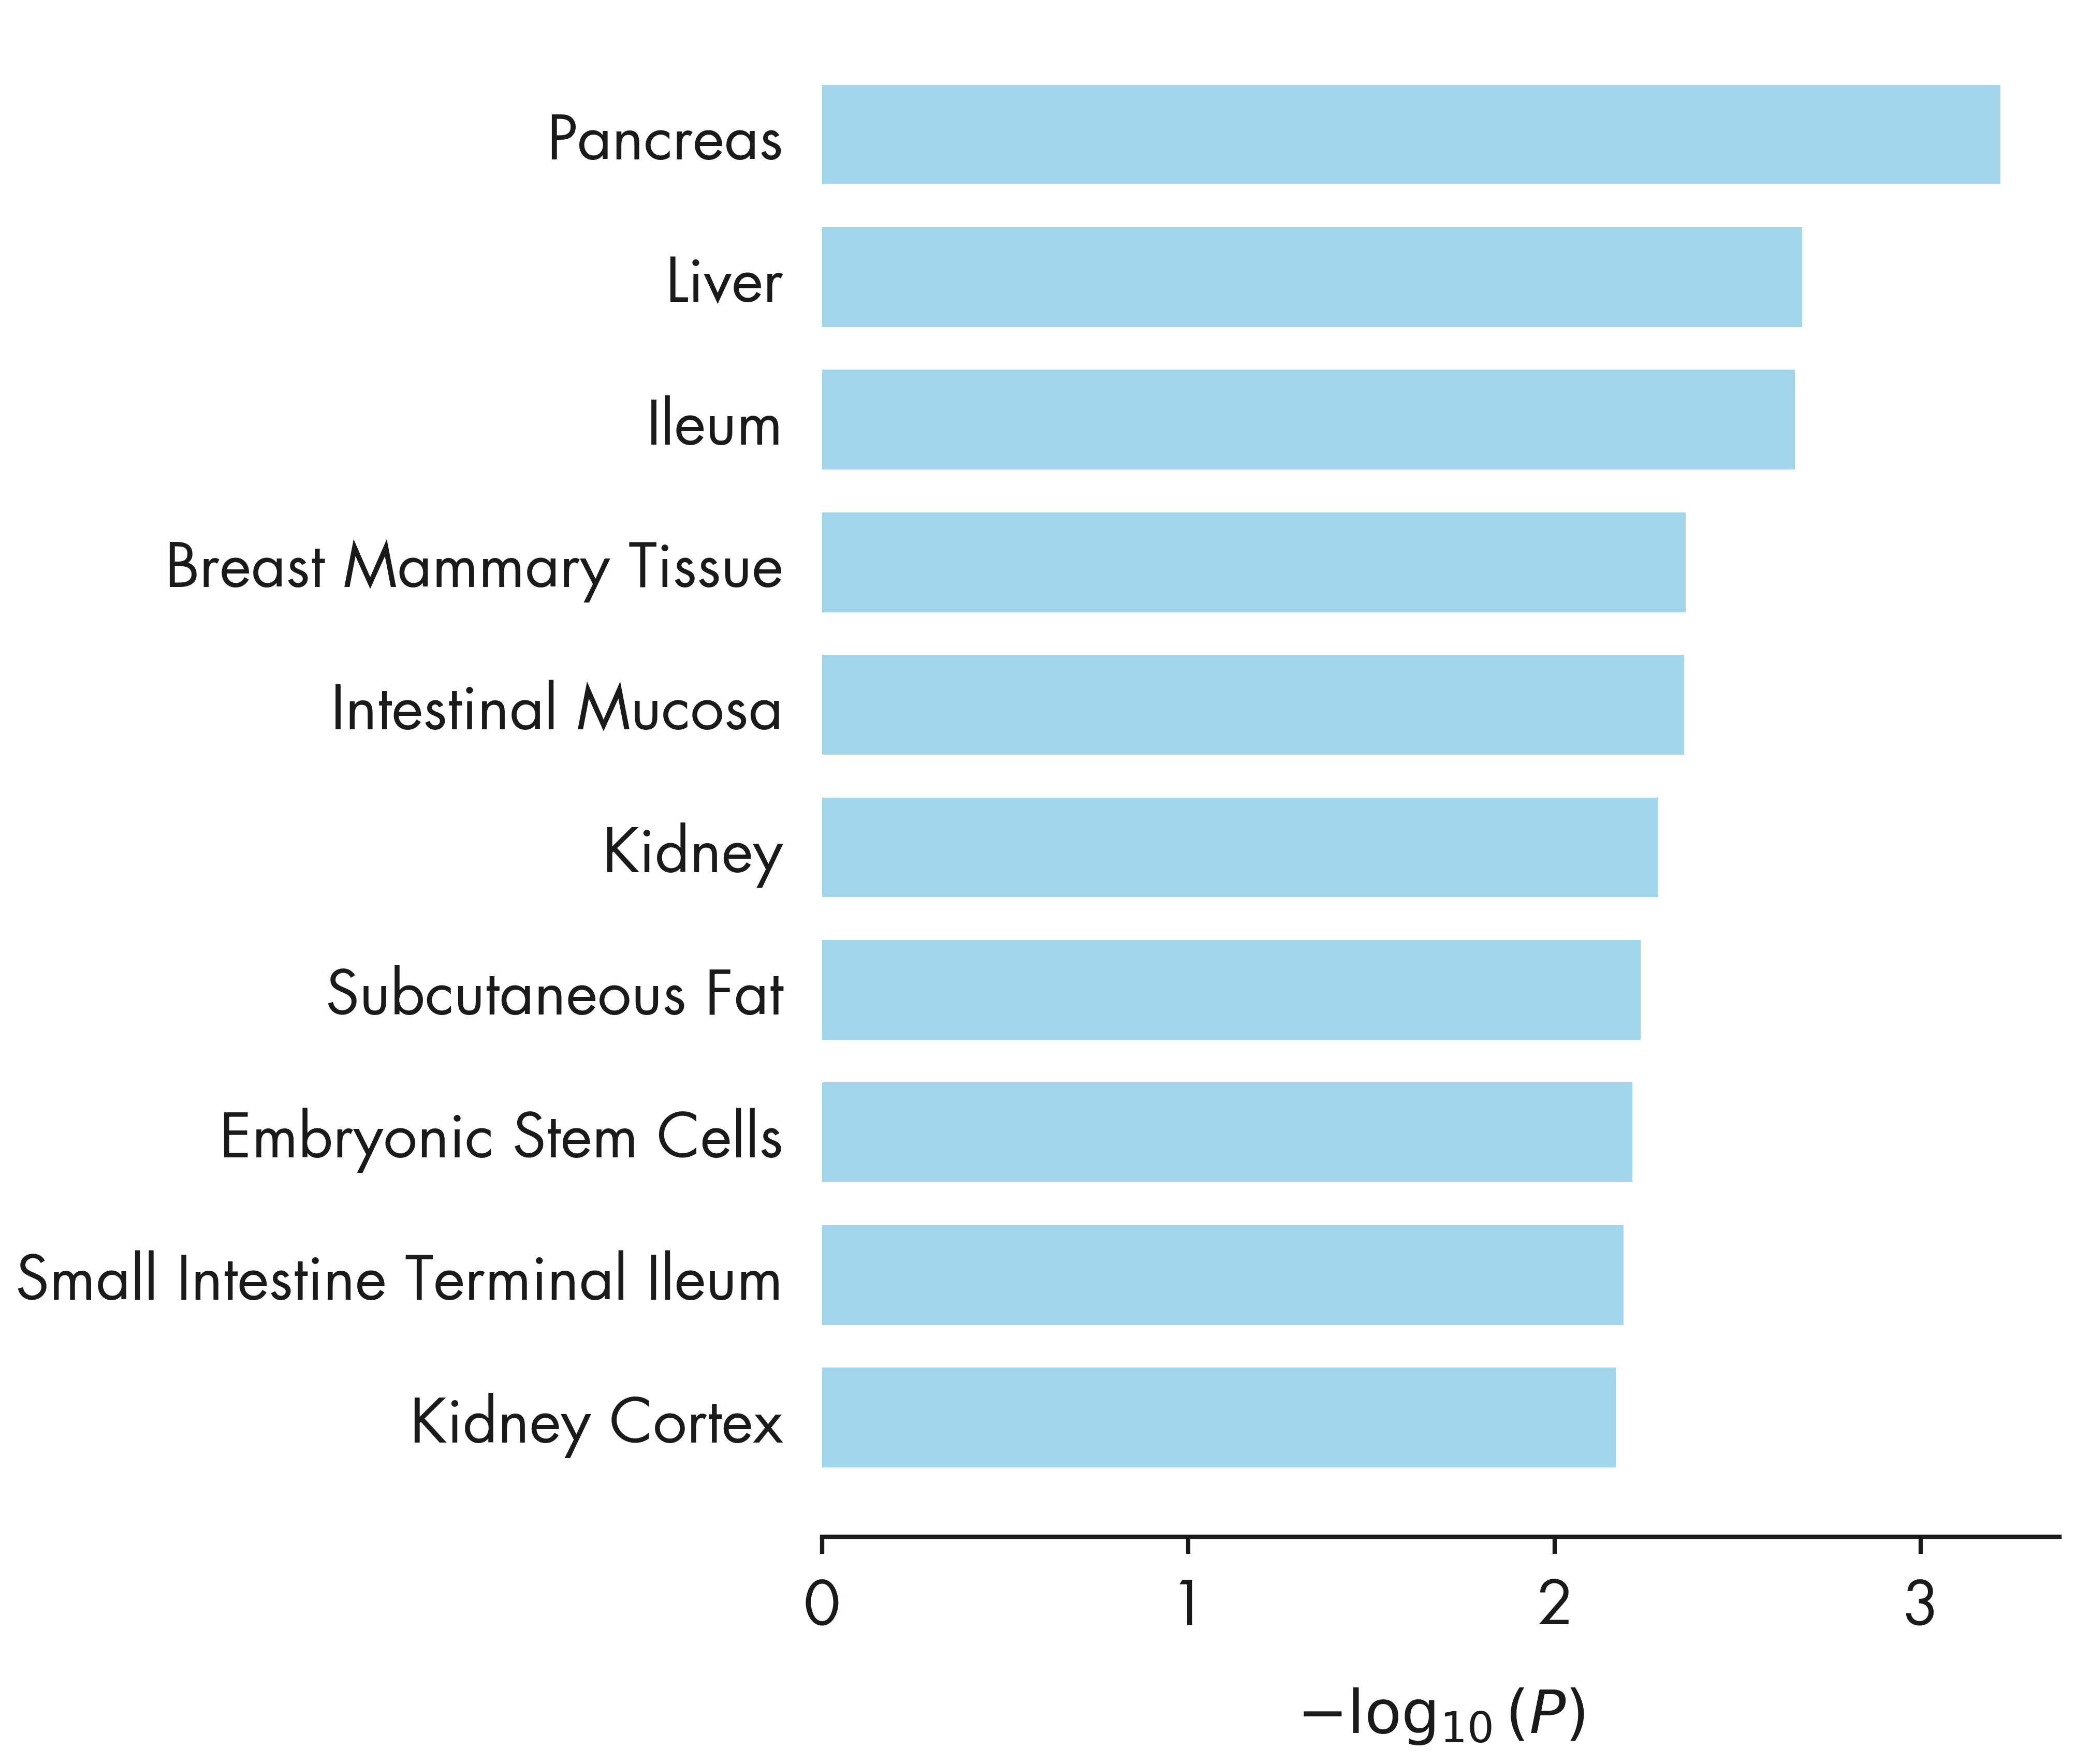

In [39]:
fig = plt.figure(figsize = (14, 12))
ax1 = fig.add_subplot(111)
    
xvals = -np.log10(cts_df["Coefficient_P_value"].to_numpy())
yvals = np.arange(n_plot_tissues)[::-1]

ax1.barh(yvals, xvals, align = 'center', height = 0.7, color = nygc_colors['lightblue'], edgecolor = 'None')
ax1.set_yticks(yvals)
ax1.set_yticklabels(cts_df["Name"])

for side in ['top', 'right', 'left']:
    ax1.spines[side].set_visible(False)

ax1.tick_params(left=False)
ax1.set_xlabel(r"$-\log_{10}(P)$")
# ax1.set_title(method_names[method])

plt.tight_layout()
plt.savefig('../plots/ashg24/cts_enrichment_topfactor_t1d.png', bbox_inches='tight')
plt.show()